In [3]:
pip install imblearn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 KB 2.4 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

# Persiapan Dataframe

In [7]:
# Import the reviews.csv file
reviews_df = pd.read_csv('reviews.csv')
print(reviews_df.head())

                               reviewId         userName  \
0  cee6da6b-93cd-4f9d-9411-c3d1d3a4c5a7  Pengguna Google   
1  1866196a-5cb5-47c3-8e8e-762ccc2c3026  Pengguna Google   
2  0354f2f2-b662-4125-bf4b-ec50c6e7518b  Pengguna Google   
3  ffc03c79-861a-43da-92e8-4f1382efe5cf  Pengguna Google   
4  d1d723bc-4d84-47f5-90ca-581d78b5ca7c  Pengguna Google   

                                           userImage  \
0  https://play-lh.googleusercontent.com/EGemoI2N...   
1  https://play-lh.googleusercontent.com/EGemoI2N...   
2  https://play-lh.googleusercontent.com/EGemoI2N...   
3  https://play-lh.googleusercontent.com/EGemoI2N...   
4  https://play-lh.googleusercontent.com/EGemoI2N...   

                                             content  score  thumbsUpCount  \
0                    Lebih mudah pake aplikasi Brimo      5              0   
1  Maaf mau tanya kenapa hari ini brimo saya tida...      5              0   
2                     Bagus cepat memudah kan urusan      5         

In [13]:
reviews_df = reviews_df.drop(columns=['reviewId', 'userName', 'userImage', 'thumbsUpCount', 'replyContent', 'repliedAt', 'appVersion'])
reviews_df

,content,score,reviewCreatedVersion,at,sentiment,sentiment_score
0,Lebih mudah pake aplikasi Brimo,5,NaN,2024-12-10 11:49:55,LABEL_1,0.999722
1,Maaf mau tanya kenapa hari ini brimo saya tida...,5,2.74.0,2024-12-10 11:46:18,LABEL_0,0.999910
2,Bagus cepat memudah kan urusan,5,2.74.0,2024-12-10 11:44:32,LABEL_1,0.999538
3,good👍👍,5,2.74.0,2024-12-10 11:44:30,LABEL_1,0.999611
4,"Ternyata Brimo praktis, cepat dan gak ribet blas",5,2.74.0,2024-12-10 11:43:47,LABEL_1,0.999802
...,...,...,...,...,...,...
9995,"Bagaimana ini, setelah update tidak bisa di kl...",4,2.72.0,2024-11-17 08:51:37,LABEL_0,0.999865
9996,Transfer lebih mudah,5,NaN,2024-11-17 08:48:55,LABEL_1,0.996939
9997,Memudahkan semua transaksi pembayarN,5,2.72.0,2024-11-17 08:48:12,LABEL_1,0.999675
9998,Transaksi cepat,5,2.73.0,2024-11-17 08:36:49,LABEL_1,0.999231


# Labelling

In [9]:
from transformers import pipeline
import torch

pretrained_name = "w11wo/indonesian-roberta-base-indolem-sentiment-classifier-fold-0"

# Check if GPU is available and set the device accordingly
device = 0 if torch.cuda.is_available() else -1

nlp = pipeline(
    "sentiment-analysis",
    model=pretrained_name,
    tokenizer=pretrained_name,
    device=device
)

nlp("Pelayanan hotel ini sangat baik.")

[{'label': 'LABEL_1', 'score': 0.9998635053634644}]

In [10]:
from tqdm.notebook import tqdm

# Apply the nlp function to the content column and extract both label and score
results = []
for content in tqdm(reviews_df['content'], desc="Processing"):
    result = nlp(content)
    results.append({'sentiment': result[0]['label'], 'sentiment_score': result[0]['score']})

# Convert the results to a DataFrame and concatenate with the original DataFrame
results_df = pd.DataFrame(results)
reviews_df = pd.concat([reviews_df, results_df], axis=1)


Processing:   0%|          | 0/10000 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [14]:
reviews_df.to_csv('labelled_reviews_df.csv', index=False)

In [72]:
reviews_df = pd.read_csv('labelled_reviews_df.csv')
reviews_df

,content,score,reviewCreatedVersion,at,sentiment,sentiment_score
0,Lebih mudah pake aplikasi Brimo,5,NaN,2024-12-10 11:49:55,LABEL_1,0.999722
1,Maaf mau tanya kenapa hari ini brimo saya tida...,5,2.74.0,2024-12-10 11:46:18,LABEL_0,0.999910
2,Bagus cepat memudah kan urusan,5,2.74.0,2024-12-10 11:44:32,LABEL_1,0.999538
3,good👍👍,5,2.74.0,2024-12-10 11:44:30,LABEL_1,0.999611
4,"Ternyata Brimo praktis, cepat dan gak ribet blas",5,2.74.0,2024-12-10 11:43:47,LABEL_1,0.999802
...,...,...,...,...,...,...
9995,"Bagaimana ini, setelah update tidak bisa di kl...",4,2.72.0,2024-11-17 08:51:37,LABEL_0,0.999865
9996,Transfer lebih mudah,5,NaN,2024-11-17 08:48:55,LABEL_1,0.996939
9997,Memudahkan semua transaksi pembayarN,5,2.72.0,2024-11-17 08:48:12,LABEL_1,0.999675
9998,Transaksi cepat,5,2.73.0,2024-11-17 08:36:49,LABEL_1,0.999231


# EDA

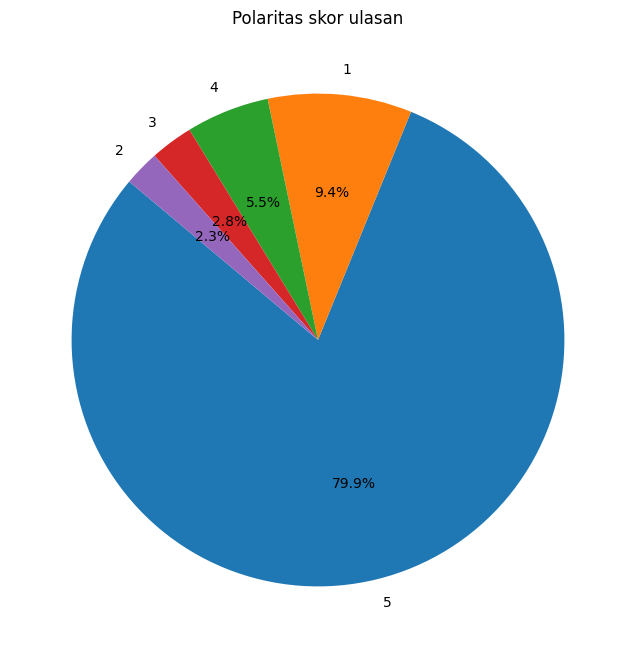

In [ ]:
# Count the occurrences of each score
score_counts = reviews_df['score'].value_counts()

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(score_counts, labels=score_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Polaritas Skor Ulasan')
plt.show()

/tmp/ipykernel_1881222/3749928522.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=version_counts.index, y=version_counts.values, palette='viridis')


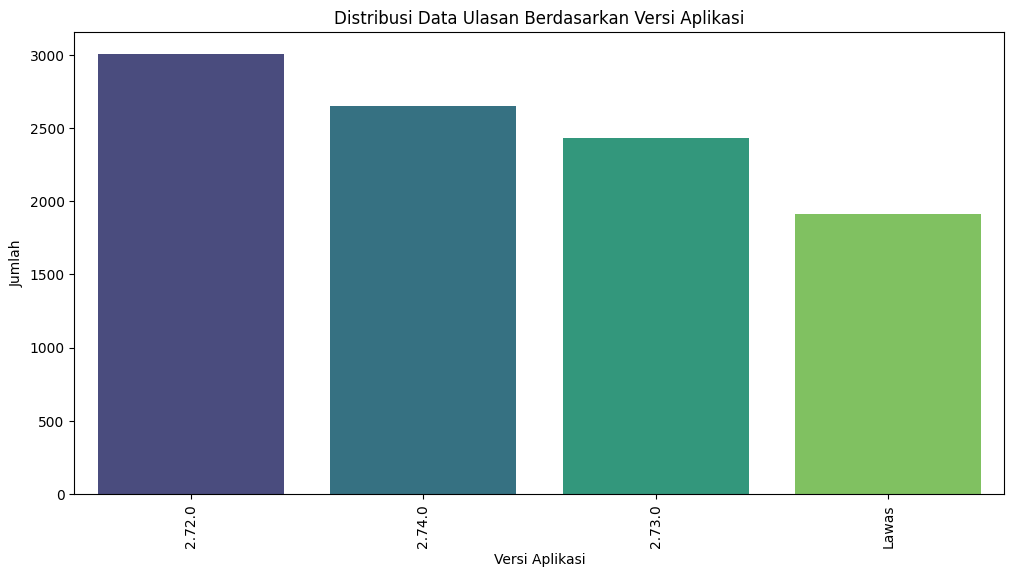

In [73]:
# Define the threshold version
threshold_version = '2.71.2'

# Function to compare versions
def compare_versions(version, threshold):
    if pd.isna(version):
        return 'Lawas'
    return 'Lawas' if version < threshold else version

# Apply the function to the reviewCreatedVersion column
reviews_df['reviewCreatedVersion'] = reviews_df['reviewCreatedVersion'].apply(lambda x: compare_versions(x, threshold_version))

# Count the occurrences of each reviewCreatedVersion
version_counts = reviews_df['reviewCreatedVersion'].value_counts()

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=version_counts.index, y=version_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Versi Aplikasi')
plt.ylabel('Jumlah')
plt.title('Distribusi Data Ulasan Berdasarkan Versi Aplikasi')
plt.show()

/tmp/ipykernel_1881222/1006170857.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=month_counts.index.astype(str), y=month_counts.values, palette='viridis')


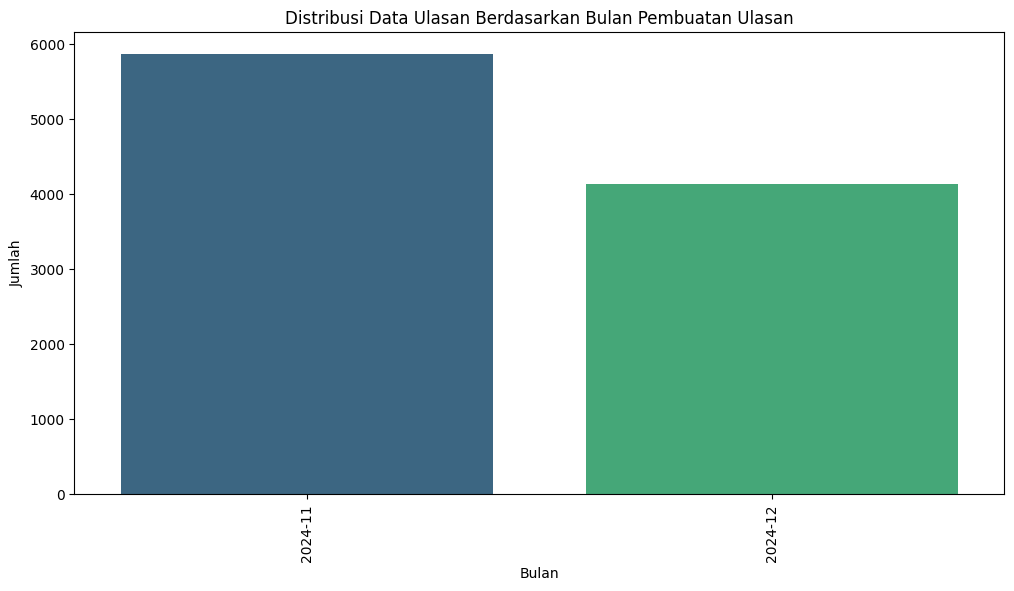

In [66]:
# Convert the 'at' column to datetime format
reviews_df['at'] = pd.to_datetime(reviews_df['at'])

# Extract the month from the 'at' column
reviews_df['month'] = reviews_df['at'].dt.to_period('M')

# Count the occurrences of each month
month_counts = reviews_df['month'].value_counts().sort_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x=month_counts.index.astype(str), y=month_counts.values, palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Bulan')
plt.ylabel('Jumlah')
plt.title('Distribusi Data Ulasan Berdasarkan Bulan Pembuatan Ulasan')
plt.show()

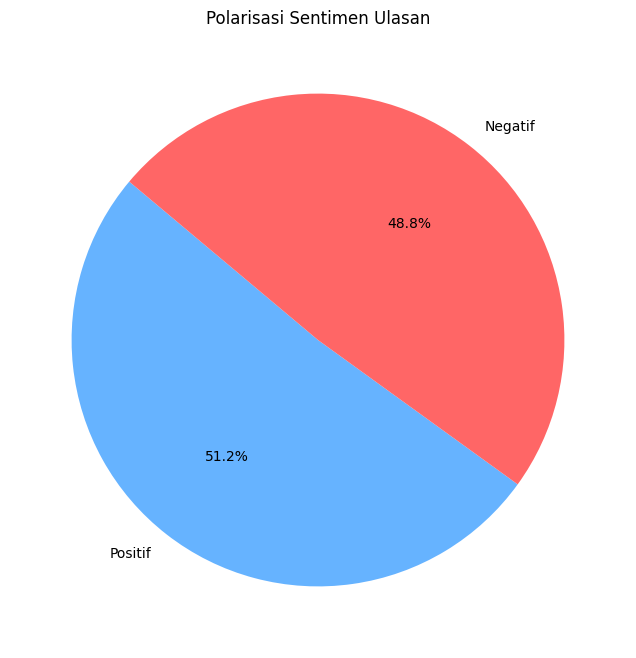

In [65]:
# Count the occurrences of each sentiment
sentiment_counts = reviews_df['sentiment'].value_counts()

# Define the labels and colors for the pie chart
labels = ['Positif', 'Negatif']
colors = ['#66b3ff', '#ff6666']

# Plot the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Polarisasi Sentimen Ulasan')
plt.show()

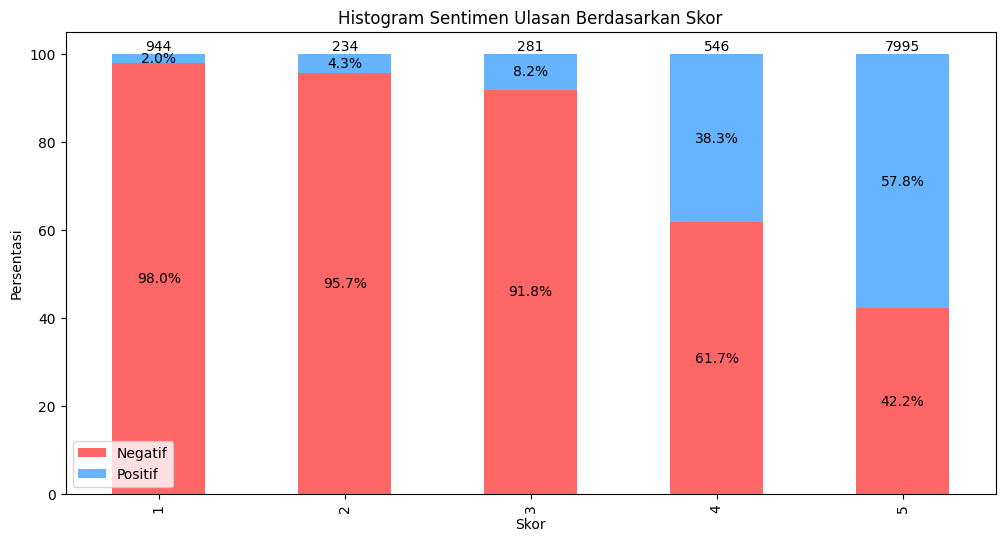

In [74]:
# Pivot the DataFrame to get the count of each sentiment for each score
pivot_df = reviews_df.pivot_table(index='score', columns='sentiment', aggfunc='size', fill_value=0)

# Calculate the percentage for each sentiment
pivot_percentage_df = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

# Define the colors for the stacked bar plot
colors = ['#ff6666', '#66b3ff']  # Red for Negative (LABEL_0) and Blue for Positive (LABEL_1)

# Create a stacked bar plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the bars
bars = pivot_percentage_df.plot(kind='bar', stacked=True, color=colors, ax=ax)

# Add text on top of each bar
for i in range(len(pivot_df)):
    total = pivot_df.iloc[i].sum()
    ax.text(i, 100, f'{total}', ha='center', va='bottom')

# Add percentage text inside each segment of the stacked bar
for bar in bars.containers:
    ax.bar_label(bar, label_type='center', fmt='%.1f%%')

# Set labels and title
ax.set_xlabel('Skor')
ax.set_ylabel('Persentasi')
ax.set_title('Histogram Sentimen Ulasan Berdasarkan Skor')
ax.legend(['Negatif', 'Positif'])

# Show the plot
plt.show()


# SVM

In [75]:
# Extract features and labels
X = reviews_df['content']
y = reviews_df['sentiment']

# Convert text data to numerical features using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8000, 5000)
X_test shape: (2000, 5000)
y_train shape: (8000,)
y_test shape: (2000,)


In [76]:
# Initialize the SVM model
svm_model = SVC(kernel='linear', random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svm_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

     LABEL_0       0.87      0.86      0.86      1033
     LABEL_1       0.85      0.86      0.85       967

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

[[884 149]
 [136 831]]


In [79]:
from sklearn.metrics import precision_recall_fscore_support

# Initialize lists to store the precision, recall, and f1-score for each fold
precision_list = []
recall_list = []
f1_list = []

# Perform manual 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold = 1

for train_index, test_index in kf.split(X_tfidf):
    X_train_fold, X_test_fold = X_tfidf[train_index], X_tfidf[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # Train the model on the current fold
    svm_model.fit(X_train_fold, y_train_fold)
    
    # Make predictions on the test set of the current fold
    y_pred_fold = svm_model.predict(X_test_fold)
    
    # Print the classification report for the current fold
    print(f"Fold {fold} Classification Report:")
    print(classification_report(y_test_fold, y_pred_fold))
    
    # Calculate precision, recall, and f1-score for the current fold
    precision, recall, f1, _ = precision_recall_fscore_support(y_test_fold, y_pred_fold, average='weighted')
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)
    
    fold += 1

# Calculate the mean precision, recall, and f1-score across all folds
mean_precision = np.mean(precision_list)
mean_recall = np.mean(recall_list)
mean_f1 = np.mean(f1_list)

print("\nMean Classification Report for 10-Fold Cross-Validation:")
print(f"Precision: {mean_precision:.4f}")
print(f"Recall: {mean_recall:.4f}")
print(f"F1-Score: {mean_f1:.4f}")

Fold 1 Classification Report:
              precision    recall  f1-score   support

     LABEL_0       0.85      0.84      0.85       510
     LABEL_1       0.84      0.85      0.84       490

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000

Fold 2 Classification Report:
              precision    recall  f1-score   support

     LABEL_0       0.87      0.87      0.87       523
     LABEL_1       0.86      0.86      0.86       477

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000

Fold 3 Classification Report:
              precision    recall  f1-score   support

     LABEL_0       0.86      0.84      0.85       521
     LABEL_1       0.83      0.85      0.84       479

    accuracy                           0.85      1000
   macro avg       0.85      0.85     